In [ ]:
import numpy as np
import sklearn
import pandas as pd
import os
import time
import datetime
import matplotlib.pyplot as plt

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
project_dir = "/content/drive/Shareddrives/data/CS188"
data = os.path.join(project_dir, "training_dataset_V3.csv")

In [ ]:
raw_df = pd.read_csv(data)

In [ ]:
raw_df.head()

,Unnamed: 0,dt,weekday,year,id_driver,id_carrier_number,dim_carrier_type,dim_carrier_company_name,home_base_city,home_base_state,carrier_trucks,num_trucks,interested_in_drayage,port_qualified,signup_source,ts_signup,ts_first_approved,days_signup_to_approval,driver_with_twic,dim_preferred_lanes,first_load_date,most_recent_load_date,load_day,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,total_loads
0,0,2019-12-16,Monday,2019,21350,U0109015,Owner Operator,CA&F TRUCKING,Maywood,CA,"[""poweronly""]",1.0,yes,yes,Other,2019-04-08 18:19:00+00:00,2019-04-22 18:49:47+00:00,14.0,yes,NaN,2019-10-24,2021-02-17,2019-12-16,2,0,438,438,0,45,45,483
1,1,2021-01-15,Friday,2021,36437,C0097727,Fleet,New opportunities inc,Los Angeles,CA,"[""poweronly"", ""boxtruck""]",15.0,yes,yes,Mobile,2020-04-18 01:01:13+00:00,2020-05-06 22:09:23+00:00,18.0,no,NaN,2020-10-14,2021-02-03,2021-01-15,1,2,72,74,0,1,1,75
2,2,2019-12-26,Thursday,2019,19323,U0107081,Owner Operator,RAS,Compton,CA,"[""poweronly""]",1.0,yes,yes,Other,2019-02-11 08:43:49+00:00,2019-07-17 20:35:13+00:00,156.0,yes,NaN,2019-12-12,2020-09-25,2019-12-26,1,0,180,180,0,2,2,182
3,3,2021-02-10,Wednesday,2021,34809,C0094651,Fleet,NFS asset Drayage,Lynwood,CA,"[""poweronly"", ""dryvan""]",195.0,yes,yes,Other,2019-03-04 20:50:37+00:00,2019-03-04 21:03:38+00:00,0.0,yes,NaN,2020-06-18,2021-02-17,2021-02-10,3,0,0,0,0,0,0,62
4,4,2017-07-24,Monday,2017,4728,U0094376,Owner Operator,joes transportation,Norco,CA,"[""dryvan""]",1.0,not specified,no,Other,2017-01-17 00:05:12+00:00,2019-03-22 00:26:25+00:00,794.0,no,NaN,2017-01-17,2017-10-11,2017-07-24,2,57,0,57,314,0,314,371


---

**1. Generate labels**

---

In [ ]:
# convert most_recent_load_date from string to timestamp
raw_df['most_recent_load_date'] = pd.to_datetime(raw_df['most_recent_load_date'])

In [ ]:
# set 75th percentile threshold
most_recent_load_date_threshold = raw_df.most_recent_load_date.quantile(0.75)
total_loads_threshold = raw_df.total_loads.quantile(0.75)

In [ ]:
# label drivers in the 75th percentile of ‘loads’ and ‘most_recent_load_date’ are assigned a label of 1
raw_df['label'] = (raw_df['most_recent_load_date'] >= most_recent_load_date_threshold) & (raw_df['total_loads'] >= total_loads_threshold)
raw_df["label"] = raw_df["label"].astype(int)
raw_df['label'].value_counts()

0    73021
1    10393
Name: label, dtype: int64

In [ ]:
rows_to_drop = 40000
query = raw_df.query("label==0")
if len(query) >= rows_to_drop:
  df_to_drop = query.sample(n=rows_to_drop, random_state=42)
  raw_df = raw_df.drop(df_to_drop.index)

In [ ]:
raw_df['label'].value_counts()

0    33021
1    10393
Name: label, dtype: int64

---

**2. Drop total_loads and ‘most_recent_load_date’ from your data frame**

---

In [ ]:
df = raw_df.drop(['total_loads', 'most_recent_load_date'], axis=1)
df.head()

,Unnamed: 0,dt,weekday,year,id_driver,id_carrier_number,dim_carrier_type,dim_carrier_company_name,home_base_city,home_base_state,carrier_trucks,num_trucks,interested_in_drayage,port_qualified,signup_source,ts_signup,ts_first_approved,days_signup_to_approval,driver_with_twic,dim_preferred_lanes,first_load_date,load_day,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,label
0,0,2019-12-16,Monday,2019,21350,U0109015,Owner Operator,CA&F TRUCKING,Maywood,CA,"[""poweronly""]",1.0,yes,yes,Other,2019-04-08 18:19:00+00:00,2019-04-22 18:49:47+00:00,14.0,yes,NaN,2019-10-24,2019-12-16,2,0,438,438,0,45,45,1
3,3,2021-02-10,Wednesday,2021,34809,C0094651,Fleet,NFS asset Drayage,Lynwood,CA,"[""poweronly"", ""dryvan""]",195.0,yes,yes,Other,2019-03-04 20:50:37+00:00,2019-03-04 21:03:38+00:00,0.0,yes,NaN,2020-06-18,2021-02-10,3,0,0,0,0,0,0,0
6,6,2019-08-26,Monday,2019,15945,U0103984,Owner Operator,felipe gomez carranza,Ontario,CA,"[""dryvan""]",1.0,not specified,no,Other,2018-11-08 01:56:46+00:00,2018-12-03 20:44:16+00:00,25.0,no,NaN,2018-12-06,2019-08-26,1,0,0,0,137,0,137,0
9,9,2021-02-01,Monday,2021,34503,C0094651,Fleet,NFS asset Drayage,Lynwood,CA,"[""poweronly"", ""dryvan""]",195.0,yes,yes,Other,2019-03-04 20:50:37+00:00,2019-03-04 21:03:38+00:00,0.0,yes,NaN,2020-05-14,2021-02-01,2,0,0,0,0,0,0,0
14,14,2020-07-30,Thursday,2020,34784,C0097561,Fleet,ADC TRANSPORT INC,Paramount,CA,"[""poweronly""]",9.0,yes,yes,Other,2020-02-27 00:41:40+00:00,2020-02-28 22:31:09+00:00,1.0,yes,NaN,2020-06-15,2020-07-30,7,11,429,440,0,167,167,1


---

**3. Run some basic statistics on your variables including correlations with labels and
report findings**

---

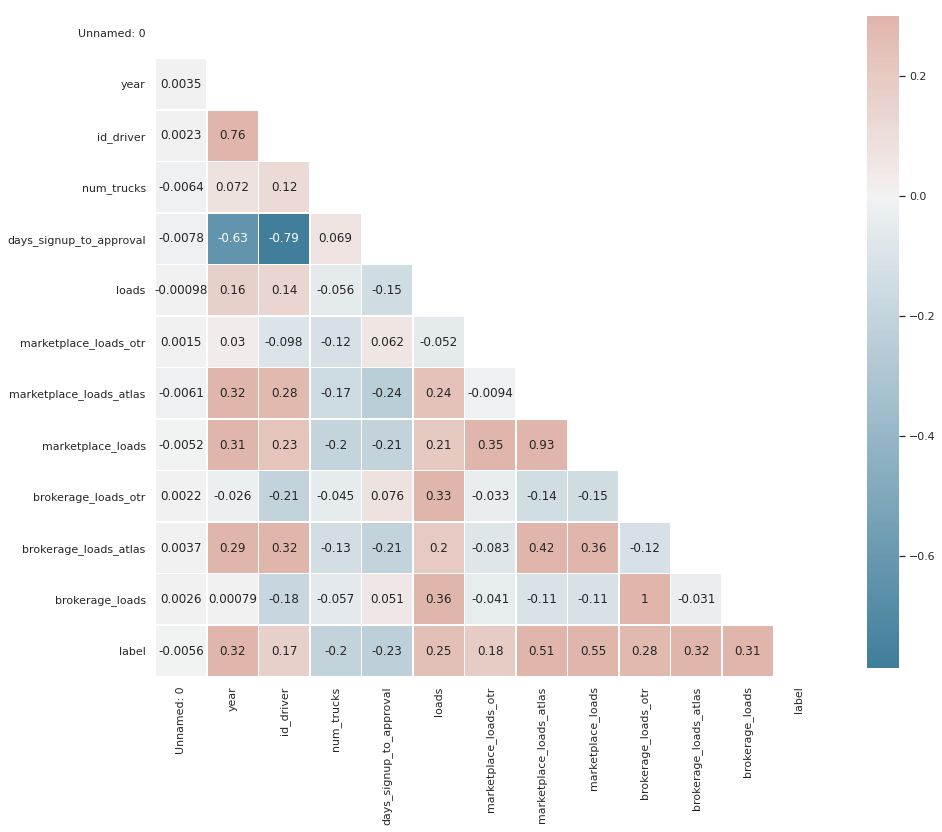

In [ ]:
import matplotlib.transforms
import seaborn as sns

sns.set(style="white")
corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f,ax = plt.subplots(figsize=(15,15))

cmap = sns.diverging_palette(230,20,as_cmap=True)
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .8})

plt.yticks(rotation = 0)
plt.show()

From the correlation graphs above, we are able to find that there is a strong negative correlation between days_signup_to_approval and year. Also, there is a positive coorelation between `marketplace_loads` and `marketplace_loads_atlas`, `brokerage_loads` and `brokerage_loads_otr`.

In [ ]:
df.describe()

,Unnamed: 0,year,id_driver,num_trucks,days_signup_to_approval,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,label
count,43414.000000,43414.000000,43414.000000,43385.000000,37223.000000,43414.000000,43414.000000,43414.000000,43414.000000,43414.000000,43414.000000,43414.000000,43414.000000
mean,41661.775602,2019.083568,18801.902981,19.910130,273.267066,2.287741,33.946538,105.899502,139.846040,186.869144,17.059958,203.929101,0.239393
std,24131.267913,1.325277,11547.705496,45.857461,381.792615,2.997736,94.063826,246.211665,262.740835,517.649316,47.726520,513.976349,0.426718
min,0.000000,2015.000000,20.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20718.250000,2018.000000,8985.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000
50%,41622.000000,2019.000000,17716.000000,2.000000,18.000000,1.000000,2.000000,0.000000,17.000000,15.000000,0.000000,44.000000,0.000000
75%,62708.750000,2020.000000,29477.500000,11.000000,439.500000,3.000000,24.000000,60.000000,147.000000,128.000000,3.000000,164.000000,0.000000
max,83413.000000,2021.000000,38096.000000,195.000000,1653.000000,102.000000,902.000000,1324.000000,1348.000000,4266.000000,371.000000,4266.000000,1.000000


---

**4. Create a data feature extraction plan and implement a pipeline to execute it**

---

In [ ]:
df.head()

,Unnamed: 0,dt,weekday,year,id_driver,id_carrier_number,dim_carrier_type,dim_carrier_company_name,home_base_city,home_base_state,carrier_trucks,num_trucks,interested_in_drayage,port_qualified,signup_source,ts_signup,ts_first_approved,days_signup_to_approval,driver_with_twic,dim_preferred_lanes,first_load_date,load_day,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,label
0,0,2019-12-16,Monday,2019,21350,U0109015,Owner Operator,CA&F TRUCKING,Maywood,CA,"[""poweronly""]",1.0,yes,yes,Other,2019-04-08 18:19:00+00:00,2019-04-22 18:49:47+00:00,14.0,yes,NaN,2019-10-24,2019-12-16,2,0,438,438,0,45,45,1
3,3,2021-02-10,Wednesday,2021,34809,C0094651,Fleet,NFS asset Drayage,Lynwood,CA,"[""poweronly"", ""dryvan""]",195.0,yes,yes,Other,2019-03-04 20:50:37+00:00,2019-03-04 21:03:38+00:00,0.0,yes,NaN,2020-06-18,2021-02-10,3,0,0,0,0,0,0,0
6,6,2019-08-26,Monday,2019,15945,U0103984,Owner Operator,felipe gomez carranza,Ontario,CA,"[""dryvan""]",1.0,not specified,no,Other,2018-11-08 01:56:46+00:00,2018-12-03 20:44:16+00:00,25.0,no,NaN,2018-12-06,2019-08-26,1,0,0,0,137,0,137,0
9,9,2021-02-01,Monday,2021,34503,C0094651,Fleet,NFS asset Drayage,Lynwood,CA,"[""poweronly"", ""dryvan""]",195.0,yes,yes,Other,2019-03-04 20:50:37+00:00,2019-03-04 21:03:38+00:00,0.0,yes,NaN,2020-05-14,2021-02-01,2,0,0,0,0,0,0,0
14,14,2020-07-30,Thursday,2020,34784,C0097561,Fleet,ADC TRANSPORT INC,Paramount,CA,"[""poweronly""]",9.0,yes,yes,Other,2020-02-27 00:41:40+00:00,2020-02-28 22:31:09+00:00,1.0,yes,NaN,2020-06-15,2020-07-30,7,11,429,440,0,167,167,1


In [ ]:
df.nunique()

Unnamed: 0                  43414
dt                           1853
weekday                         7
year                            7
id_driver                    4005
id_carrier_number            2011
dim_carrier_type                2
dim_carrier_company_name     1945
home_base_city                397
home_base_state                38
carrier_trucks                 15
num_trucks                     30
interested_in_drayage           2
port_qualified                  2
signup_source                   2
ts_signup                    2011
ts_first_approved            1499
days_signup_to_approval       572
driver_with_twic                2
dim_preferred_lanes            41
first_load_date              1357
load_day                     1853
loads                          62
marketplace_loads_otr         108
marketplace_loads_atlas       196
marketplace_loads             228
brokerage_loads_otr           216
brokerage_loads_atlas         101
brokerage_loads               241
label         

In [ ]:
features_dropped = ['Unnamed: 0', "dt", "weekday",  "year", "id_driver", 
                    "id_carrier_number", 'dim_carrier_company_name', 
                    'ts_signup', 'ts_first_approved', 'first_load_date', 
                    'load_day', 'days_signup_to_approval', 
                    'dim_preferred_lanes', 'home_base_city']
categorical_features = ['dim_carrier_type', 'driver_with_twic', 'home_base_state', 
                        'carrier_trucks', 'interested_in_drayage', 'port_qualified', 
                        'signup_source']
numerical_features = ['num_trucks',  
                      'loads', 'marketplace_loads_otr', 'marketplace_loads_atlas', 
                      'marketplace_loads', 'brokerage_loads_otr', 
                      'brokerage_loads_atlas', 'brokerage_loads', 'loads_per_truck']

In [ ]:
other_home_base_state = 'home_base_state_not_indicated'
# other_home_base_city = 'home_base_city_not_indicated'

df['home_base_state'].fillna(other_home_base_state, inplace=True)
# df['home_base_city'].fillna(other_home_base_city, inplace=True)

df['num_trucks'].fillna(1, inplace=True)

In [ ]:
# Augment Features
df["loads_per_truck"] = df["loads"]/df["num_trucks"]

In [ ]:
dropped_df = df.drop(features_dropped, axis=1)
dropped_df.isnull().sum()

dim_carrier_type           0
home_base_state            0
carrier_trucks             0
num_trucks                 0
interested_in_drayage      0
port_qualified             0
signup_source              0
driver_with_twic           0
loads                      0
marketplace_loads_otr      0
marketplace_loads_atlas    0
marketplace_loads          0
brokerage_loads_otr        0
brokerage_loads_atlas      0
brokerage_loads            0
label                      0
loads_per_truck            0
dtype: int64

In [ ]:
df_y = dropped_df['label'].copy()
df_x = dropped_df.drop('label', axis=1)
df_x.shape, df_y.shape

((43414, 16), (43414,))

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

num_pipeline = Pipeline([
      ('std_scaler', StandardScaler()),                     
  ])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, numerical_features),
    ("cat", OneHotEncoder(), categorical_features),
])

In [ ]:
train_prepared = full_pipeline.fit_transform(df_x)
train_prepared.shape

(43414, 73)

In [ ]:
from sklearn.model_selection import train_test_split
df_y = dropped_df['label']
train_X, test_X, train_y, test_y = train_test_split(train_prepared, df_y, test_size=0.2, random_state=42)
train_X.shape, test_X.shape, train_y.shape, test_y.shape

((34731, 73), (8683, 73), (34731,), (8683,))

In [ ]:
type(train_y.to_numpy())

numpy.ndarray

In [ ]:
type(train_X.toarray())

numpy.ndarray

---

**5. Implement a basic Linear Regression to find and
interpret important features**

---

In [ ]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

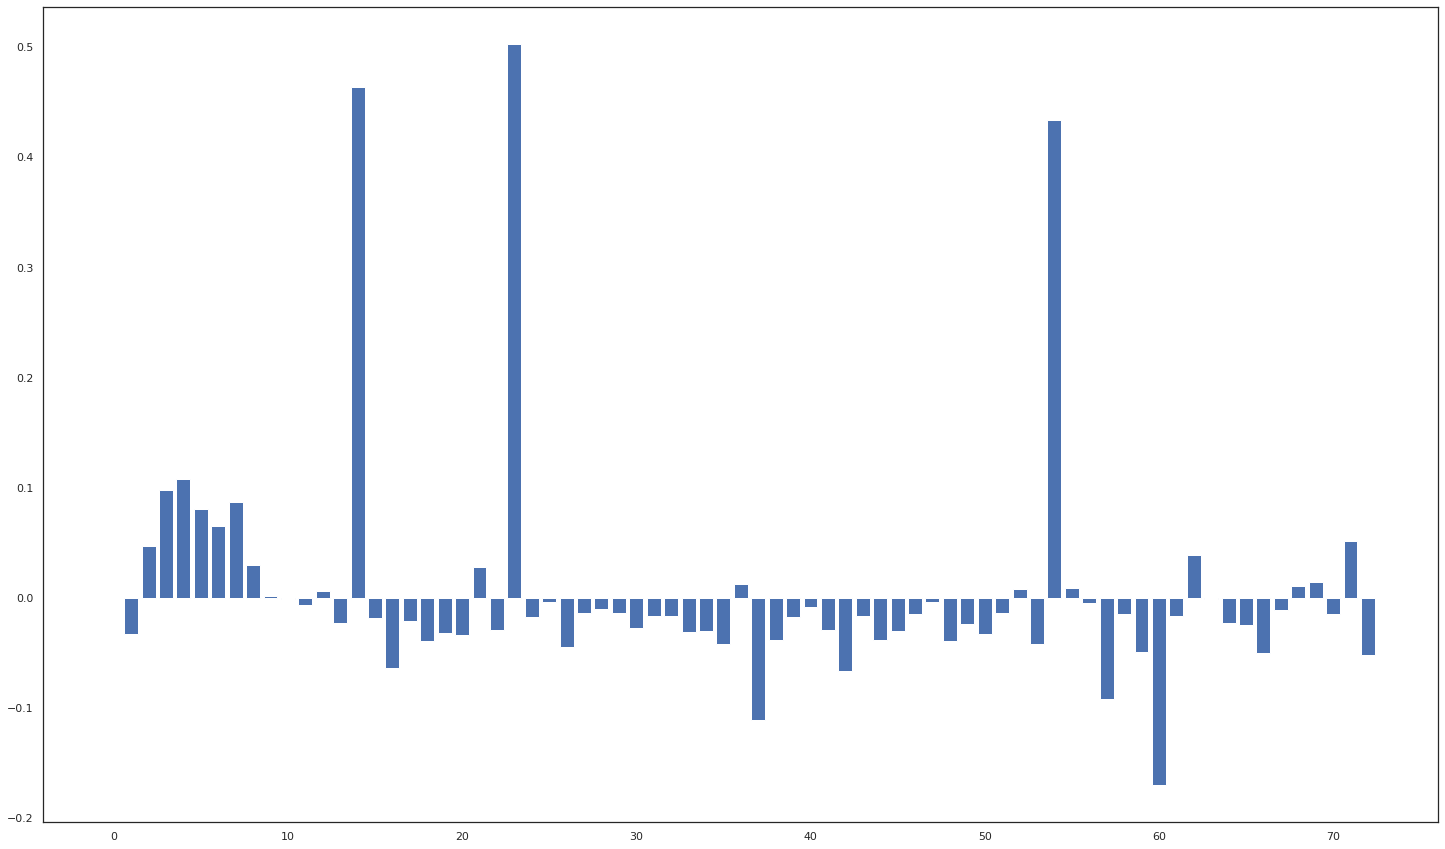

In [ ]:
# Linear Regression Feature Importance
model = LinearRegression()
model.fit(train_X, train_y)
importance = model.coef_

# for i,v in enumerate(importance):
# 	  print('Feature: %0d, Score: %.5f' % (i,v))

plt.figure(figsize=(25, 15))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


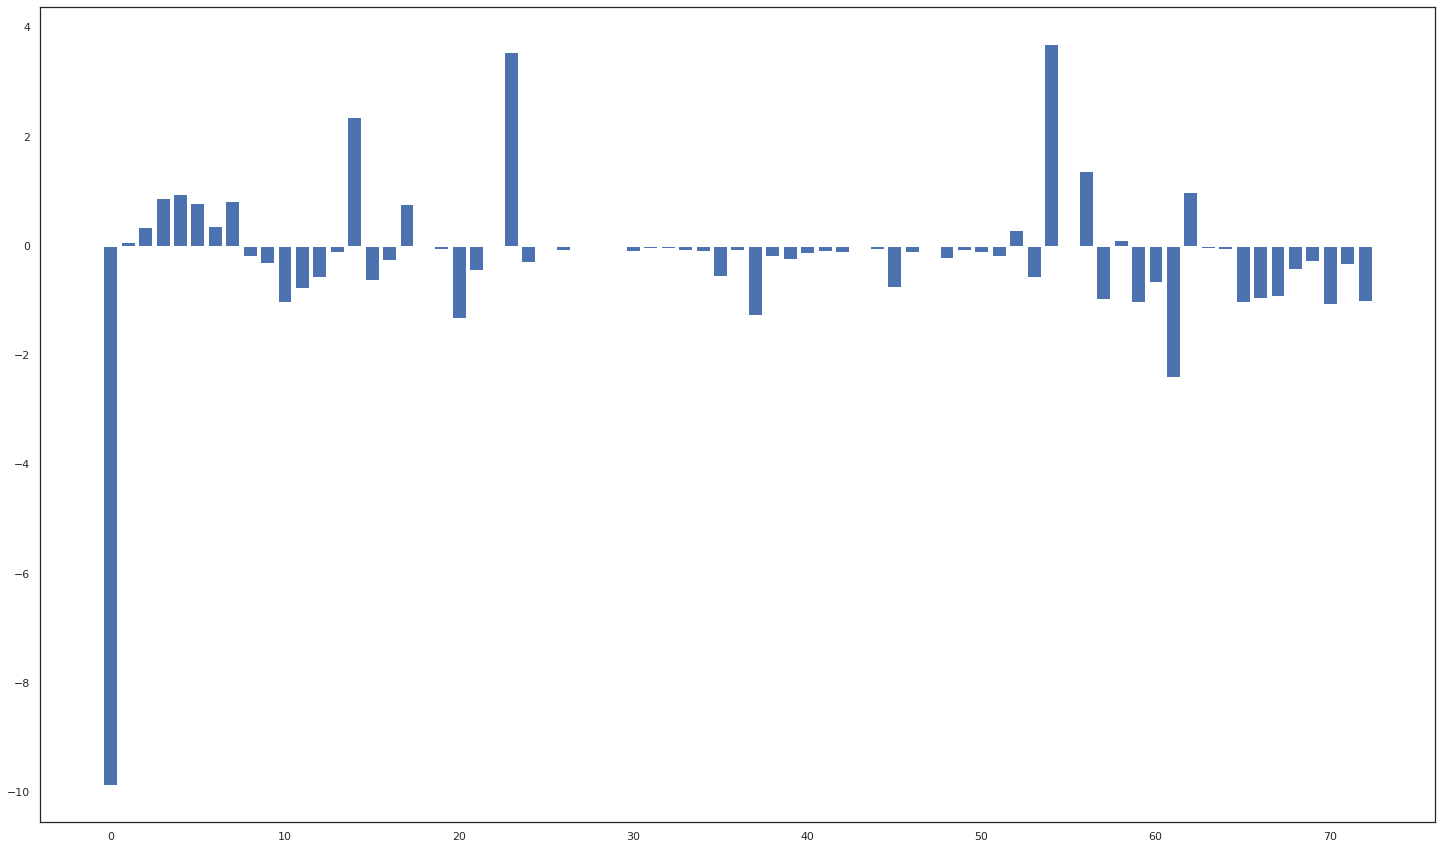

In [ ]:
# Logistic Regression Feature Importance
model = LogisticRegression()
model.fit(train_X, train_y)
importance = model.coef_[0]

# for i,v in enumerate(importance):
# 	  print('Feature: %0d, Score: %.5f' % (i,v))

plt.figure(figsize=(25, 15))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

---

**6. Implement Principle Component Analysis (PCA)**

---

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
train_X_PCA = pca.fit_transform(train_X.toarray())
test_X_PCA = pca.fit_transform(test_X.toarray())

In [ ]:
train_X_PCA.shape, test_X_PCA.shape

((34731, 10), (8683, 10))

In [ ]:
train_X_PCA

array([[ 1.58997452e+00,  4.23276975e+00,  8.85648795e-02, ...,
         3.96968775e-02, -5.94580481e-01, -1.65385849e+00],
       [-1.27086914e+00, -6.74718550e-01,  3.00911874e-01, ...,
         7.63860527e-04,  1.04221454e-01, -9.96076978e-02],
       [ 3.08107751e+00,  2.60645356e-01, -1.62998780e+00, ...,
        -1.48831640e+00, -4.55421998e-01, -1.62474450e-01],
       ...,
       [ 3.72190071e+00,  5.73229362e-01, -6.71255984e-02, ...,
         1.35697909e-02, -2.44353884e-02,  5.09744623e-01],
       [ 3.29230585e+00,  7.06563824e-02, -4.40846345e-02, ...,
         4.41166355e-03,  1.13387302e-01,  6.31338682e-01],
       [ 2.06764139e+00, -4.50308461e-01, -1.04828475e+00, ...,
        -7.50748841e-01, -1.46969322e-01, -1.16356263e-01]])

In [ ]:
print(pca.explained_variance_ratio_)

[0.28185906 0.18903636 0.12477708 0.09551251 0.08193667 0.05760123
 0.04223376 0.03684491 0.0206223  0.01426004]


---

**7. Employ an ensemble method to your classification exercise**

---

In [ ]:
# For 9: Cross-Validate training results
# might want to add: (Optional: employ a stratifiedshufflesplit as well to ensure equitable distribution along a key parameter)
from sklearn.metrics import f1_score, make_scorer
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

kfold = model_selection.KFold(n_splits=10)
num_trees = 100
bagging_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=num_trees, random_state=42)
f1_scorer = make_scorer(f1_score)
results = model_selection.cross_val_score(bagging_clf, train_X_PCA, train_y, scoring=f1_scorer, cv=kfold)
print(results.mean())

0.9973647237245802


In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'base_estimator__max_depth' : [1, 2, 3, 4, 5],
    'n_estimators' : [10, 100, 200]
}

bagging_clf = GridSearchCV(BaggingClassifier(DecisionTreeClassifier()), param_grid, scoring = f1_scorer, cv = 5)
bagging_clf.fit(train_X_PCA, train_y)
y_bagging_pred = bagging_clf.predict(test_X_PCA)
print(bagging_clf.best_params_)
print(f1_score(test_y, y_bagging_pred))

{'base_estimator__max_depth': 5, 'n_estimators': 200}
0.7660020986358868


---

**8. Develop a Neural Net classifier**

---

In [ ]:
X_train_nn_pca = train_X_PCA
y_train_nn = train_y.to_numpy()
X_test_nn_pca = test_X_PCA
y_test_nn = test_y.to_numpy()


In [ ]:
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier

nn_clf = MLPClassifier( hidden_layer_sizes=(5, 5, 5), activation='relu', solver='sgd',    
                       learning_rate='constant', learning_rate_init=0.01, 
                       alpha=0.0001, max_iter=300, 
                       random_state=42)
nn_clf.fit(train_X, train_y)
y_pred = nn_clf.predict(test_X)
f1_score(test_y, y_pred)

0.9701456890374971

In [ ]:
nn_clf = MLPClassifier( hidden_layer_sizes=(5, 5, 5), activation='relu', solver='sgd',    
                       learning_rate='adaptive', learning_rate_init=0.04,
                       alpha=0.001, max_iter=300, 
                       random_state=42)
nn_clf.fit(train_X, train_y)
y_pred = nn_clf.predict(test_X)
print(f1_score(test_y, y_pred))

0.9792970630717381


In [ ]:
nn_clf = MLPClassifier( hidden_layer_sizes=(5, 5, 5), activation='relu', solver='adam',    
                       alpha=0.001, max_iter=300, 
                       random_state=42)
nn_clf.fit(train_X, train_y)
y_pred = nn_clf.predict(test_X)
print(f1_score(test_y, y_pred))

0.969711423801574


In [ ]:
nn_pca_clf = MLPClassifier( hidden_layer_sizes=(5, 5, 5), activation='relu', solver='sgd',    
                       learning_rate='constant', learning_rate_init=0.01, 
                       alpha=0.0001, max_iter=300, 
                       random_state=42)
nn_pca_clf.fit(X_train_nn_pca, y_train_nn)
y_pred = nn_pca_clf.predict(X_test_nn_pca)
print(f1_score(y_test_nn, y_pred))

0.7354368932038835

**9. Cross-Validate training result**

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
kfold = model_selection.KFold(n_splits=10)
num_trees = 100
bagging_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=num_trees, random_state=42)
f1_scorer = make_scorer(f1_score)

In [ ]:
#model for bagging classifier
results = cross_val_score(bagging_clf, train_X_PCA, train_y, scoring=f1_scorer, cv=kfold)

In [ ]:
print(results)
print("Bagging classifier has %f accuracy with a standard deviation of %f" % (results.mean(), results.std()))

[0.9993921  0.99583581 0.99811912 0.99574985 0.99700419 0.99825885
 0.99827883 0.99764706 0.99697153 0.99638989]
Bagging classifier has 0.997365 accuracy with a standard deviation of 0.001121


In [ ]:
# NN classifier
results = cross_val_score(nn_clf, train_X_PCA, train_y, scoring=f1_scorer, cv=kfold)
print(results)
print("NN classifier has %f accuracy with a standard deviation of %f" % (results.mean(), results.std()))

[0.91333333 0.93893557 0.93006993 0.9254902  0.91588785 0.94401756
 0.94302767 0.9256927  0.94447624 0.93386094]
NN classifier has 0.931479 accuracy with a standard deviation of 0.010791


In [ ]:
#Bagging classifier with stratified shuffle split

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
results = cross_val_score(bagging_clf, train_X_PCA, train_y, scoring=f1_scorer, cv=cv)
print(results)
print("Bagging classifier has %f accuracy with a standard deviation of %f" % (results.mean(), results.std()))

[0.99541376 0.99640719 0.99701017 0.99482072 0.99621137]
Bagging classifier has 0.995973 accuracy with a standard deviation of 0.000770


In [ ]:
# NN classifier with stratified shuffle split
results = cross_val_score(nn_clf, train_X_PCA, train_y, scoring=f1_scorer, cv=cv)
print(results)
print("NN classifier has %f accuracy with a standard deviation of %f" % (results.mean(), results.std()))

[0.9286905  0.93415638 0.94002999 0.93863764 0.93930311]
NN classifier has 0.936164 accuracy with a standard deviation of 0.004262
